# 21M.387 Fundamentals of Music Processing
## Problem Set 9: Audio Decomposition

Make sure all your answers and plots display when the code block is run. You can leave word-based answers in code comments or markdown cells.

You may use any fmplib functions from __previous__ units in your answers. You may __not__ use any fmplib functions from the current unit in your answers (unless explicitly noted). But you can use the current unit's fmplib for testing your code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['image.interpolation'] = 'nearest'

fmp.documentation_button()

## Exercise 1

The STFT $\mathcal{X}[h,k]$ is a $51 \times 14$ matrix created from a signal $x[n]$ with the parameters:
- $N = 100$, the window length
- $H = 75$, the hop size
- Rectangular Window
- No centering

What is the windowing effect that must be "undone" to properly reconstruct the signal $x[n]$ from $\mathcal{X}[h,k]$? In other words, what function $W[n]$ must be used to create
$$x_r[n] = {\tilde x[n] \over W[n]}$$

Create $W[n]$ and plot it.

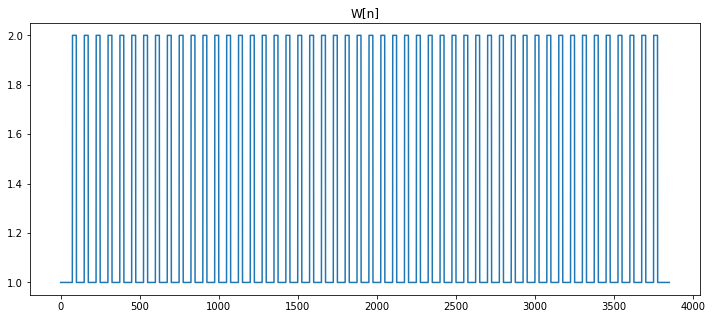

In [2]:
k = 14
hops = 51
N = 100
H = 75
Wn = np.zeros(N + (hops-1) * H)
win = np.ones(N)
for n in range(hops):
    win_shift = np.zeros(len(Wn))
    win_shift[n*H:n*H+N] += win
    Wn += win_shift

plt.title('W[n]')
plt.plot(Wn)
plt.show()

## Exercise 2a

From the given signal, create the harmonic and percussive median filtered power spectrograms:
$\tilde{\mathcal{Y}}^h[n,k]$ and $\tilde{\mathcal{Y}}^p[n,k]$ with parameters:
- $N = 4096$
- $H = 1024$
- $L_h = 19$ (harmonic median filter length)
- $L_p = 31$ (percussive median filter length)

You can use `fmp.stft` and `scipy.signal.medfilt`.

Set them to variables `filt_h` and `filt_h`, and plot them.

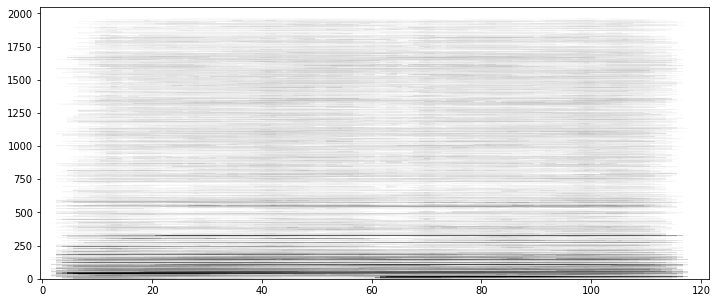

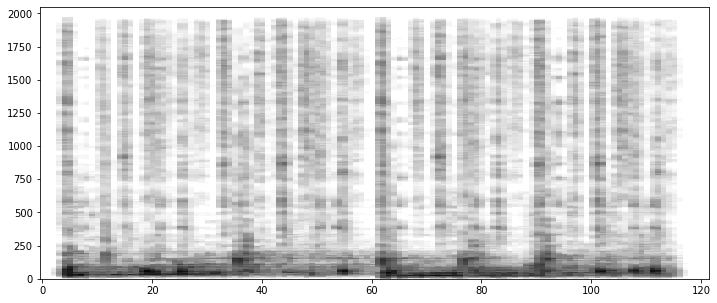

In [3]:
from scipy.signal import medfilt
snd = fmp.load_wav("audio/latin_loop.wav")
fs = 22050

fft_len = 4096
hop_size = 1024
# power spectrogram:
stft = fmp.stft(snd, fft_len, hop_size)
spec = np.abs(stft) ** 2

L_h = 19
L_p = 31

filt_h = medfilt(spec, (1, L_h))
fmp.plot_spectrogram(filt_h, cmap='Greys', colorbar=False)
plt.show()

filt_p = medfilt(spec, (L_p, 1))
fmp.plot_spectrogram(filt_p, cmap='Greys', colorbar=False)
plt.show()

## Exercise 2b

Instead of creating the usual two masks, create three binary masks from the filtered spectrograms:

$$
\mathcal{M}^h[n,k] = 
\left\{
\begin{aligned} 
1,& \text{  if } \tilde{\mathcal{Y}}^h[n,k] \ge \beta \cdot \tilde{\mathcal{Y}}^p[n,k] \\ 
0,& \text{  otherwise} \\ 
\end{aligned} 
\right. 
$$

$$
\mathcal{M}^p[n,k] = 
\left\{
\begin{aligned} 
1,& \text{  if } \tilde{\mathcal{Y}}^p[n,k] \gt \beta \cdot \tilde{\mathcal{Y}}^h[n,k] \\  
0,& \text{  otherwise} \\ 
\end{aligned} 
\right. 
$$

$$
\mathcal{M}^r[n,k] = 1 - \left( \tilde{\mathcal{M}}^h[n,k] + \tilde{\mathcal{M}}^p[n,k] \right)
$$

where $\beta$ is the _separation factor_ and $\beta \ge 1$.  

$\mathcal{M}^r[n,k]$ is the "residual" mask that captures sounds which are neither purely percussive or purely harmonic.

Write the function `make_three_masks` which creates and returns these three masks.  
Inputs:
- `filt_h`: $\tilde{\mathcal{Y}}^h[n,k]$ 
- `filt_p`: $\tilde{\mathcal{Y}}^p[n,k]$
- beta: $\beta$

Output:
- a tuple of $\mathcal{M}^h[n,k]$, $\mathcal{M}^p[n,k]$, and $\mathcal{M}^r[n,k]$

In [4]:
def make_three_masks(filt_h, filt_p, beta):
    M_h = (filt_h >= (beta * filt_p)).astype(int)
    M_p = (filt_p > (beta * filt_h)).astype(int)
    M_r = 1 - (M_h + M_p)
    
    return (M_h, M_p, M_r)

Create these masks with $\beta = 1.5$ (as `mask_h`, `mask_p`, `mask_r`) and plot them.

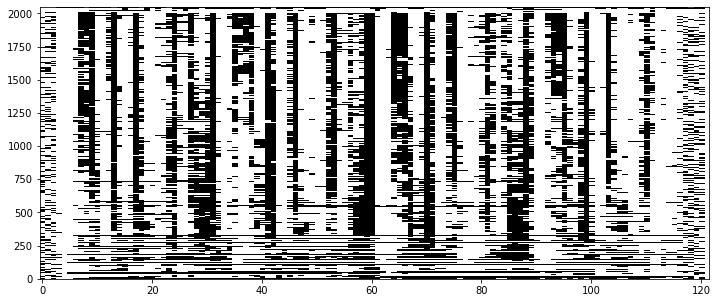

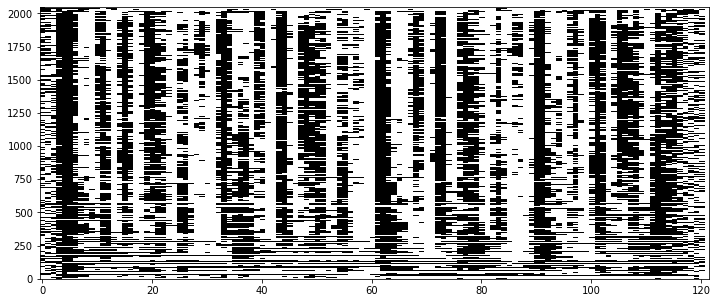

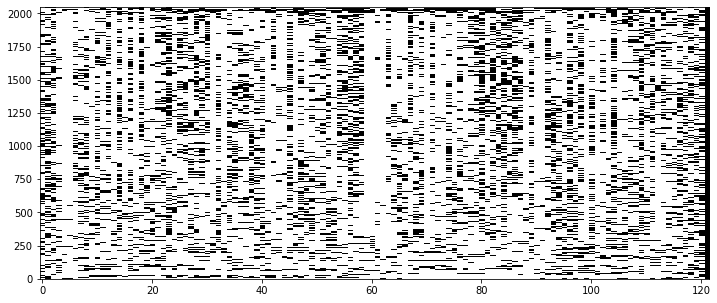

In [5]:
beta = 1.5
mask_h, mask_p, mask_r = make_three_masks(filt_h, filt_p, beta)

for m in [mask_h, mask_p, mask_r]:
    fmp.plot_spectrogram(m, cmap='Greys', colorbar=False)
    plt.show()

## Exercise 3

- Reconstruct three signals $x^h[n]$, $x^p[n]$, and $x^r[n]$ from the above masks.
- You can use `fmp.istft()`
- Listen to the audio. 
- Describe what you hear.
- Try different values of $\beta$ and describe how that changes the results.

In [6]:
@interact(beta=(1.5, 5, 0.5))
def reconstruct(beta=1.5):
    m_h, m_p, m_r = make_three_masks(filt_h, filt_p, beta)

#     fmp.plot_spectrogram(m_h, cmap='Greys', colorbar=False)
#     plt.show()    
#     fmp.plot_spectrogram(m_p, cmap='Greys', colorbar=False)
#     plt.show()    
#     fmp.plot_spectrogram(m_r, cmap='Greys', colorbar=False)
#     plt.show()    
    
    stft_h = m_h * stft
    stft_p = m_p * stft
    stft_r = m_r * stft
    
    snd_h = fmp.istft(stft_h, hop_size)
    print("re-synthesized x_h:")
    display(ipd.Audio(snd_h, rate = fs))

    snd_p = fmp.istft(stft_p, hop_size)
    print("re-synthesized x_p:")
    display(ipd.Audio(snd_p, rate = fs))

    snd_r = fmp.istft(stft_r, hop_size)
    print("re-synthesized x_r:")
    display(ipd.Audio(snd_p, rate = fs))
    

print('Answer:')
print('- x_h: harmonic sounds')
print('- x_p: percussive sounds')
print('- x_r: any remaining sounds')
print('- the higher the value of beta, the higher the "precision" of x_h and x_p, i.e., less of the percussive sounds'
      + ' bleed into the harmonic component and vice-versa')
print('- at the same time, the higher the beta, the smaller the recall, i.e., a larger fraction of sounds are deemed' 
      + ' "ambiguous" and end up on x_r')

interactive(children=(FloatSlider(value=1.5, description='beta', max=5.0, min=1.5, step=0.5), Output()), _dom_…

Answer:
- x_h: harmonic sounds
- x_p: percussive sounds
- x_r: any remaining sounds
- the higher the value of beta, the higher the "precision" of x_h and x_p, i.e., less of the percussive sounds bleed into the harmonic component and vice-versa
- at the same time, the higher the beta, the smaller the recall, i.e., a larger fraction of sounds are deemed "ambiguous" and end up on x_r


## Exercise 4

Consider the following matrix $V$, a $K \times N$ matrix with non-negative values and $K=9$, $N=7$:
<img src="images/pset_nmf.png" width=300>

Here we only consider the case of perfect non-negative decomposition, such that $V = WH$ exactly and all entries in $W$ and $H$ are non-negative.

By hand (i.e., do not run the NMF solver), determine two different decompositions, that is, two different paris of $W$ and $H$ that satisfy $V = WH$ where the rank of the decomposition is $R=3$. Do not make the second pair trivailly different from the first (by reordering rows and columns, for example).

Provide your answers as python arrays (`W1`, `H1` and `W2`, `H2`). Note that $V$ (above) is displayed with origin at the bottom left. 

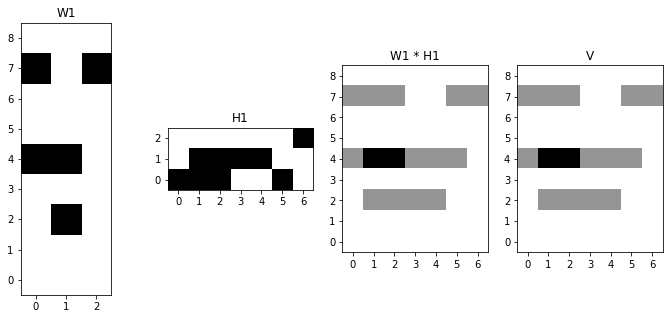

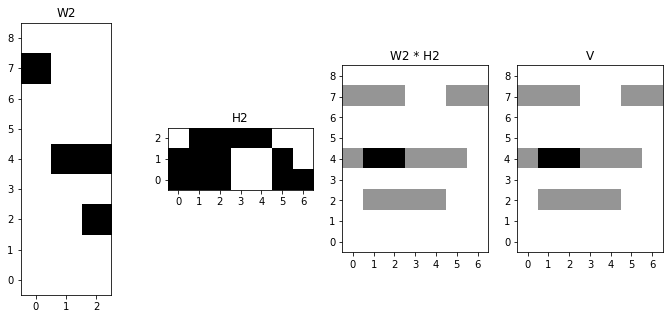

In [7]:
K = 9
N = 7
V = np.zeros((K, N)).astype(int)
V[7,0:3] = 1
V[7,5:7] = 1
V[4,0:6] = 1
V[4,1:3] = 2
V[2,1:5] = 1

R = 3
W1 = np.zeros((K, R)).astype(int)
W1[4,0:2]=1
W1[7,0]=1
W1[7,2]=1
W1[2,1]=1
H1 = np.zeros((R, N)).astype(int)
H1[0,0:3]=1
H1[0,5]=1
H1[1,1:5]=1
H1[2,6]=1

plt.subplot(1,4,1)
plt.title('W1')
plt.imshow(W1, origin='lower', cmap='Greys')
plt.subplot(1,4,2)
plt.title('H1')
plt.imshow(H1, origin='lower', cmap='Greys')
plt.xticks(np.arange(0,7))
plt.subplot(1,4,3)
plt.title('W1 * H1')
plt.imshow(np.dot(W1,H1), origin='lower', cmap='Greys')
plt.xticks(np.arange(0,7))
plt.subplot(1,4,4)
plt.title('V')
plt.imshow(V, origin='lower', cmap='Greys')
plt.xticks(np.arange(0,7))
plt.show()

W2 = np.zeros((K, R)).astype(int)
W2[7,0]=1
W2[4,1]=1
W2[4,2]=1
W2[2,2]=1
H2 = np.zeros((R, N)).astype(int)
H2[0,0:3]=1
H2[0,5:7]=1
H2[1,0:3]=1
H2[1,5]=1
H2[2,1:5]=1

plt.subplot(1,4,1)
plt.title('W2')
plt.imshow(W2, origin='lower', cmap='Greys')
plt.subplot(1,4,2)
plt.title('H2')
plt.imshow(H2, origin='lower', cmap='Greys')
plt.xticks(np.arange(0,7))
plt.subplot(1,4,3)
plt.title('W2 * H2')
plt.imshow(np.dot(W2,H2), origin='lower', cmap='Greys')
plt.xticks(np.arange(0,7))
plt.subplot(1,4,4)
plt.title('V')
plt.imshow(V, origin='lower', cmap='Greys')
plt.xticks(np.arange(0,7))
plt.show()

## Exercise 5

In order to create a useful matrix factorization, we can pre-seed $W$ with the known pitches of the music. You will do this in two parts.  
First, create the function `make_nmf_note_model(fs, fft_len, pitch)`

Inputs:
- `fs`: The sample rate
- `fft_len`: $N$, the FFT length used in making the STFT
- `pitch`: a MIDI pitch number

Output:
- A 1D vector that is a spectral model for the given pitch (with length $N/2+1$).

Strategy:  
- The resulting vector has zones of non-zero values for each harmonic of the given pitch, and zeros everywhere else.
- The first harmonic zone (fundamental frequency) has a range of $\pm 0.5$ semitones around the given pitch.
- The rest of the harmonic zones are integer multiples of these frequency bounds.
- The magnitude of each zone is $1/h$ where $h$ is the harmonic number ($h=1$ is the fundamental, $h=2$ is the 2nd harmonic, etc...).
- Fill in as many harmonic zones as will fit within the output vector.

In [36]:
def freq_to_bin(f, fs, fft_len):
    return int(f * fft_len / fs)


def make_nmf_note_model(fs, fft_len, pitch):
    n_bins = (fft_len // 2) + 1
    sm = np.zeros(n_bins)

    # fundamental frequency zone
    h_freqs = np.array([fmp.pitch_to_freq(p) for p in [pitch-.5, pitch+.5]])
    
    for h in range(1,n_bins):
        freqs = h * h_freqs
        ks = [freq_to_bin(f, fs, fft_len) for f in freqs]
        
        for k in range(ks[0], ks[1]):
            if k < n_bins:
                sm[k] = 1/h
        
    return sm

Create pitch models for pitches 60 and 72 (setting `pm_60` and `pm_72`) with $F_s = 22050$ and $N = 4096$. Plot these two functions.

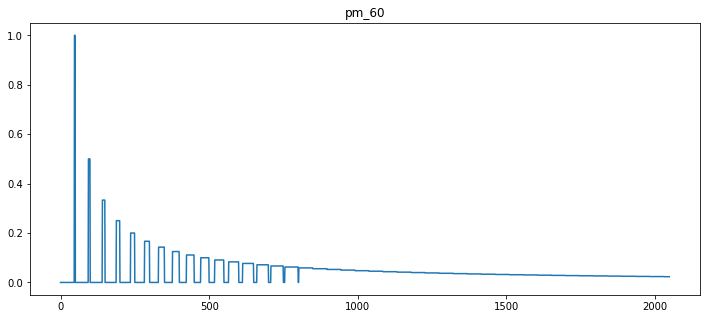

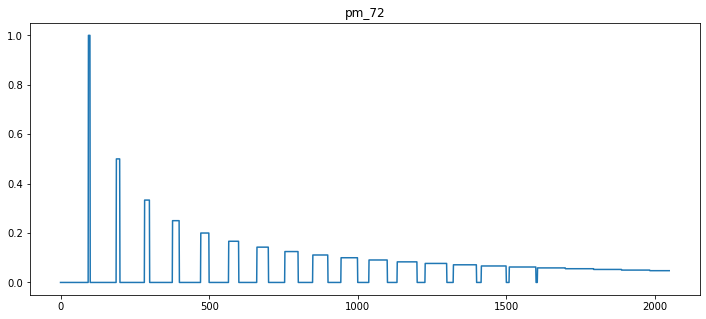

In [37]:
fs = 22050
fft_len = 4096
pm_60 = make_nmf_note_model(fs, fft_len, 60)
pm_72 = make_nmf_note_model(fs, fft_len, 72)

plt.plot(pm_60)
plt.title('pm_60')
plt.show()
plt.plot(pm_72)
plt.title('pm_72')
plt.show()

## Exercise 6

Continuing, create the function `make_nmf_template(fs, fft_len, pitches)` with the help of the above function.

Inputs:
- `fs`: The sample rate
- `fft_len`: $N$, the FFT length used in making the STFT
- `pitches`: a list of pitch

Output:
- $W$ - the initial templates matrix that contains one pitch model at each column for each of the given pitches


In [57]:
def make_nmf_template(fs, fft_len, pitches):
    return np.hstack([np.atleast_2d(make_nmf_note_model(fs, fft_len, p)).T for p in pitches])

Test your function by creating $W$ with `fs` and `fft_len` as above for pitches of the C major scale from C4 to C5, inclusive (setting `W_C_maj`). Then plot $W$.

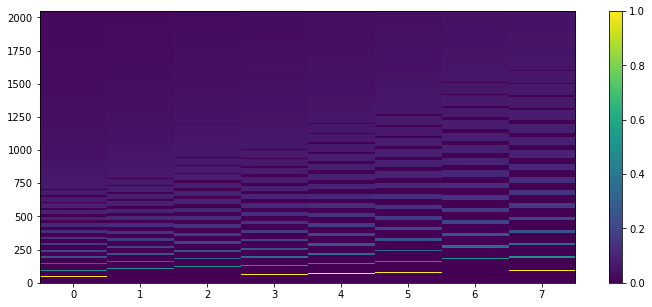

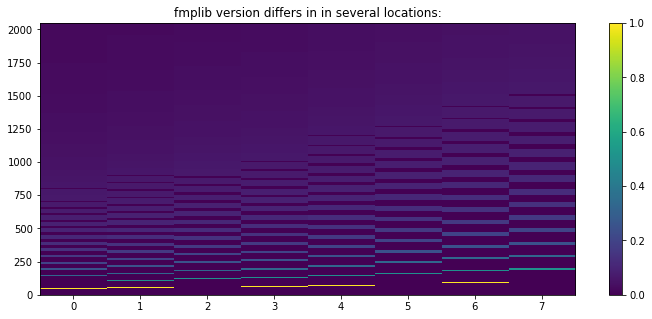

In [62]:
pitches = [60, 62, 64, 65, 67, 69, 71, 72]
W_C_maj = make_nmf_template(fs, fft_len, pitches)

plt.imshow(np.atleast_2d(W_C_maj), origin='lower', aspect='auto')
plt.colorbar();
plt.show()

# fmplib version:
x = fmp.make_nmf_template(fs, fft_len, pitches) 
plt.imshow(np.atleast_2d(x), origin='lower', aspect='auto')
plt.title('fmplib version differs in several locations:')
plt.colorbar();
plt.show()

## Exercise 7

In this Exercise, you will run the NMF algorithm on a short snippet of the Mozart _Piano Sonata in F_.  
The score is here and the audio below.

<img src="images/mozart_sonata_f.png" width=500>

In [49]:
snd = fmp.load_wav("audio/mozart_sonata_f.wav")
fs = 22050.
ipd.Audio(snd, rate=fs)

Setup:
- Create the STFT of the audio ($N=4096$, $H=1024$).
- Create the list of pitches found in this score (hint: there are 14).
- Use these pitches to create the initial $W$ matrix.
- Create the initial $H$ matrix to contains all ones.

The NMF algorithm strives to reduce the error $\phi = {\Vert V - WH \Vert}$ where $V$ is the magnitude of the STFT.
- Print the initial value of $\phi$ before running NMF (set `phi_init`).
- Run NMF to produce optimized $W$ and $H$ using `fmp.nmf(V, Wi, Hi)`. It returns a tuple of $W$ and $H$. Set `W_mozart` and `H_mozart`.
- What is the value of $\phi$ with the optimized $W$ and $H$ (set `phi_opt`)?
- Finally, plot $W$ and $H$

phi_init=1171.0911983677129
phi_opt=314.13545806036825


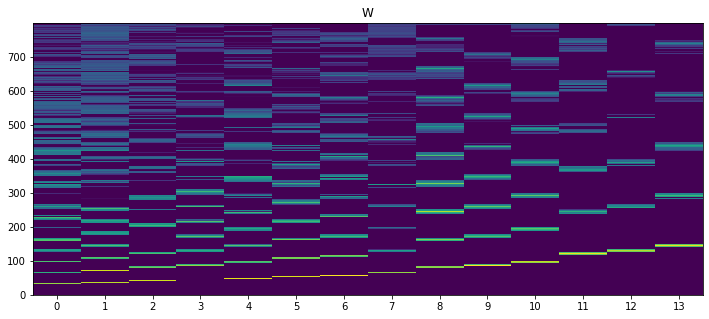

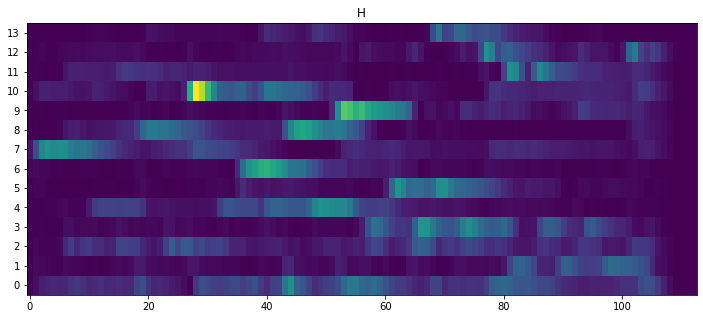

In [79]:
fft_len = 4096
hop_size = 1024
stft = fmp.stft(snd, fft_len, hop_size)

lh = [53, 55, 57, 58, 60, 62, 63]
rh = [65, 69, 70, 72, 76, 77, 79]
pitches = lh + rh

V = np.abs(stft)
K, N = V.shape
R = len(pitches)

# using fmplib version as mine yields different results:
#Wi = make_nmf_template(fs, fft_len, pitches)
Wi = fmp.make_nmf_template(fs, fft_len, pitches)
Hi = np.ones((R, N))

Vo = np.dot(Wi, Hi)
phi_init = np.linalg.norm((np.abs(stft) - Vo))
print(f'phi_init={phi_init}')

W_mozart, H_mozart = fmp.nmf(V, Wi, Hi)
V_mozart = np.dot(W_mozart, H_mozart)
phi_opt = np.linalg.norm((np.abs(stft) - V_mozart))
print(f'phi_opt={phi_opt}')

plt.imshow(np.log(W_mozart[0:800,:] + 0.001), origin='lower', aspect='auto')
plt.title('W')
plt.xticks(np.arange(R))
plt.show()
plt.imshow(H_mozart, origin='lower', aspect='auto')
plt.yticks(np.arange(R))
plt.title('H')
plt.show()

## Exercise 8

In this exercise, separate the left and right hands and create two reconstructed audio clips: $x^L[n]$ and $x^R[n]$:

- Beginning with $H$, the activations matrix, create two different (non overlapping) activation matrices: $H^L$ and $H^R$ (setting `H_left` and `H_right`).
- Create soft masks $M^L$ and $M^R$ using the equations described in the lecture notes (setting `mask_left` and `mask_right`).
- Use these masks to create two STFTs: $\mathcal{X}^L[n,k]$ and $\mathcal{X}^R[n,k]$ (setting `stft_left` and `stft_right`).
- Finally, apply the inverse STFT to create the reconstructed audio clips $x^L[n]$ and $x^R[n]$.

Play both audio clips. Describe what you hear. How good was this source separation?

In [84]:
H_left = H_mozart.copy()
H_left[7:,:] = 0
H_right = H_mozart.copy()
H_right[0:7,:] = 0
eps = 0.0000001
mask_left = np.dot(W_mozart, H_left) / (np.dot(W_mozart, H_mozart) + eps)
mask_right = np.dot(W_mozart, H_right) / (np.dot(W_mozart, H_mozart) + eps)
stft_left = stft * mask_left
stft_right = stft * mask_right

# play and describe what you hear.
snd_left = fmp.istft(stft_left, hop_size)
print("re-synthesized left hand:")
display(ipd.Audio(snd_left, rate = fs))

snd_right = fmp.istft(stft_right, hop_size)
print("re-synthesized right hand:")
display(ipd.Audio(snd_right, rate = fs))

print('Answer:')
print('- left and right hand got reasonably well separated')
print('- there is still some background noise bleeding into both resynthesized tracks')

re-synthesized left hand:


re-synthesized right hand:


Answer:
- left and right hand got reasonably well separated
- there is still some background noise bleeding into both resynthesized tracks
